# Observed Markov Models for new pipeline

Translated from R as written here: https://github.com/prio-data/viewsforecasting/tree/main/Tools/new_markov

## 0. Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import importlib
import pickle as pkl

from sklearn.metrics import mean_squared_log_error
from sklearn.metrics import mean_squared_error

# set path
import sys, os
sys.path.append(os.path.abspath(".."))

from src import markov_model
importlib.reload(markov_model)
from src.markov_model import MarkovModel

## 1.0 Try out 4 different methods for Markov model:

In [5]:
data = pd.read_parquet('../data/david_data.parquet')

In [67]:
all_features = data.columns

state_features = all_features.drop(
    ["gleditsch_ward"]
).tolist()

fatalities_features = all_features.drop(
    ["gleditsch_ward"]
).tolist()

In [68]:
random_seed = 42
partitioner_dict = {"train":(121,408),"test":(409,456)}
steps = range(1, 37)

Train for all 4 combinations:

In [69]:
models = {}

for markov_method in ["transition", "direct"]:
    for regression_method in ["single", "multi"]:

        # initialize model
        model = MarkovModel(
            partitioner_dict=partitioner_dict,
            markov_method=markov_method,
            regression_method=regression_method,
            random_state=random_seed
        )

        # fit model
        model.fit(
            data=data,
            steps=steps,
            target="ln_ged_sb",
            markov_target="ln_ged_sb",
            state_features=state_features,
            fatalities_features=fatalities_features
        )

        # save model
        model_name = f"markov_{markov_method}_{regression_method}"
        models[model_name] = model

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war and step: 1                    
Finished fitting Random Forest Regressors for all Markov states.
Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war and step: 36                    
Finished fitting Random Forest Regressors for all Markov states.
Fitting Random Forest Classifier for state: war and step: 36                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war and step: 1                    
Finished fitting Random Forest Regressors for all Markov states.
Fitting Random Forest Classifier for state: war and step: 36                      
Finished fitting Random Forest Classifi

In [22]:
# save models to pickle
with open('../model_artifacts/markov_models.pkl', 'wb') as f:
    pkl.dump(models, f)

Predict with all methods:

In [70]:
predictions = {}

for model in models:
    predictions[model] = models[model].predict(
        data=data,
        steps=steps,
    )

Predicting step 36 using transition method.                    
Finished predicting for all steps.
Predicting step 36 using transition method.                    
Finished predicting for all steps.
Predicting step 36 using direct method.                    
Finished predicting for all steps.
Predicting step 36 using direct method.                    
Finished predicting for all steps.


In [71]:
predictions_merged = pd.concat(predictions, axis=1)
predictions_merged.columns = [
    f"{model}_{col}"
    for model, col in predictions_merged.columns
]

Merge with actuals

In [72]:
actuals = data.rename_axis(index={"month_id": "target_month_id"})

# merge with actuals from data
predictions_merged = predictions_merged.merge(
    actuals[["ln_ged_sb"]],
    left_index=True,
    right_index=True
)

Plot MSLE:

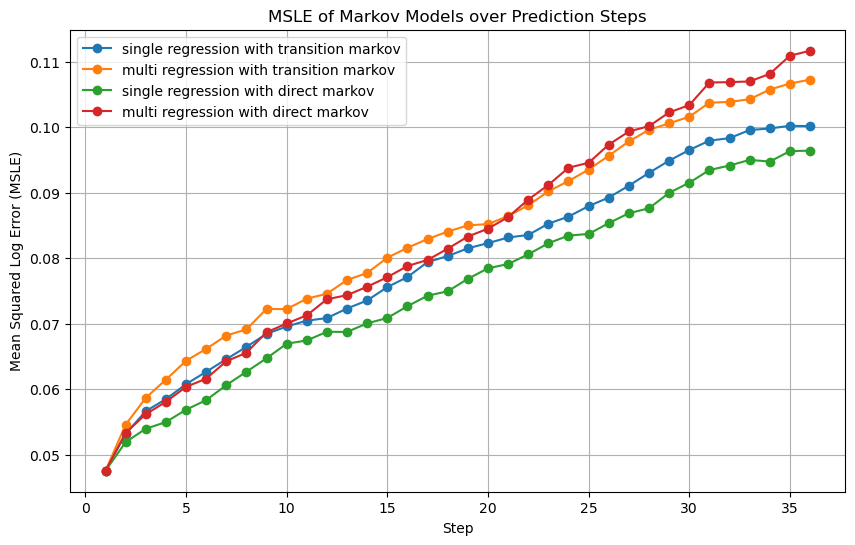

In [73]:
df = predictions_merged.copy()
df.dropna(inplace=True)

# define true values
y_true = df["ln_ged_sb"].values

msle_results = {model: [] for model in models}

for step in steps:
    for model in models:
        col_name = f"{model}_predicted_fatalities_t_min_{step}"

        value = mean_squared_log_error(y_true, df[col_name])
        msle_results[model].append(value)

msle_df = pd.DataFrame({
    "step": steps,
    **{f"{model}_msle": msle_results[model] for model in models}
})

# --- plot ---
plt.figure(figsize=(10,6))

for model in models:
    plt.plot(
        msle_df["step"],
        msle_df[f"{model}_msle"],
        marker="o",
        label=f"{models[model]._regression_method} regression with {models[model]._markov_method} markov"
    )

plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()

In [78]:
results = pd.read_parquet('../r_version/old_pipeline_version/results/markov_jointnarrow_ss_rf_custom.parquet')
predictions_david = results.reorder_levels(["country_id", "month_id"]).sort_index()
predictions_david.index.names = ["country_id", "target_month_id"]

In [79]:
final_merged = predictions_merged.merge(
    predictions_david,
    left_index=True,
    right_index=True,
)

In [81]:
final_merged.head()

markov_transition_single_predicted_fatalities_t_min_1  \
country_id target_month_id                                                          
1          409.0                                                     0.000000       
           410.0                                                     0.001422       
           411.0                                                     0.001417       
           412.0                                                     0.001402       
           413.0                                                     0.002836       

                            markov_transition_single_predicted_fatalities_t_min_2  \
country_id target_month_id                                                          
1          409.0                                                     0.000000       
           410.0                                                     0.000000       
           411.0                                                     0.001973       
           412.0                                                     0.001975       
           413.0                                                     0.001962       

                            markov_transition_single_predicted_fatalities_t_min_3  \
country_id target_month_id                                                          
1          409.0                                                     0.000000       
           410.0                                                     0.000000       
           411.0                                                     0.000000       
           412.0                                                     0.002433       
           413.0                                                     0.002434       

                            markov_transition_single_predicted_fatalities_t_min_4  \
country_id target_month_id                                                          
1          409.0                                                     0.000000       
           410.0                                                     0.000000       
           411.0                                                     0.000000       
           412.0                                                     0.000000       
           413.0                                                     0.002691       

                            markov_transition_single_predicted_fatalities_t_min_5  \
country_id target_month_id                                                          
1          409.0                                                          0.0       
           410.0                                                          0.0       
           411.0                                                          0.0       
           412.0                                                          0.0       
           413.0                                                          0.0       

                            markov_transition_single_predicted_fatalities_t_min_6  \
country_id target_month_id                                                          
1          409.0                                                          0.0       
           410.0                                                          0.0       
           411.0                                                          0.0       
           412.0                                                          0.0       
           413.0                                                          0.0       

                            markov_transition_single_predicted_fatalities_t_min_7  \
country_id target_month_id                                                          
1          409.0                                                          0.0       
           410.0                                                          0.0       
           411.0                                                          0.0       
           412.0           

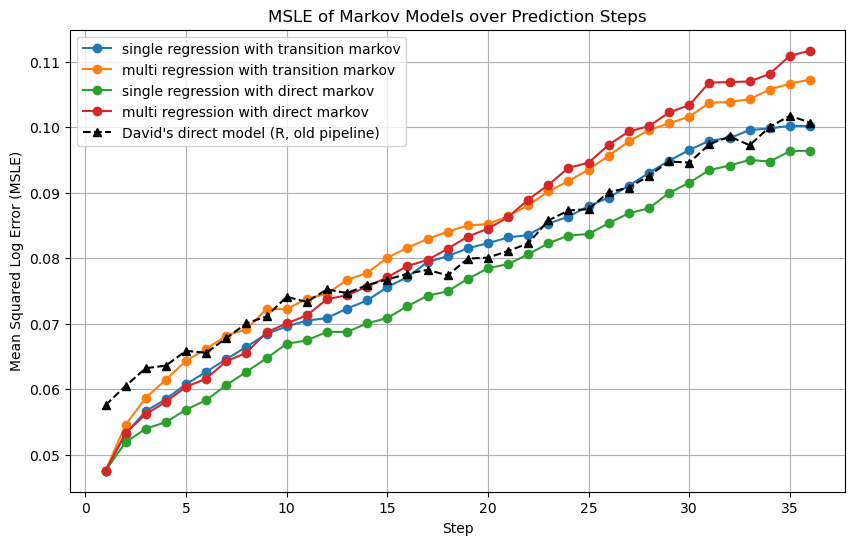

In [83]:
df = final_merged.copy()
df.dropna(inplace=True)

# define true values
y_true = df["ln_ged_sb"].values

msle_results = {model: [] for model in models}

for step in steps:
    for model in models:
        col_name = f"{model}_predicted_fatalities_t_min_{step}"

        value = mean_squared_log_error(y_true, df[col_name])
        msle_results[model].append(value)
    


david_msle = []

for step in steps:
    david_msle_val = mean_squared_log_error(y_true, df[f"step_pred_{step}"])
    david_msle.append(david_msle_val)

msle_df = pd.DataFrame({
    "step": steps,
    **{f"{model}_msle": msle_results[model] for model in models},
    "david_msle": david_msle
})

# --- plot ---
plt.figure(figsize=(10,6))

for model in models:
    plt.plot(
        msle_df["step"],
        msle_df[f"{model}_msle"],
        marker="o",
        label=f"{models[model]._regression_method} regression with {models[model]._markov_method} markov"
    )
plt.plot(msle_df["step"], msle_df["david_msle"], marker="^", label="David's direct model (R, old pipeline)", color = "black", linestyle = "--")

plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()

## 1.1 Fit models on Queryset used on old pipeline

In [2]:
data = pd.read_parquet('../data/david_data.parquet')
data.head()

ln_ged_sb_dep  gleditsch_ward  ln_ged_sb  \
month_id country_id                                             
1        1                     0.0             110        0.0   
         2                     0.0             115        0.0   
         3                     0.0              52        0.0   
         4                     0.0             101        0.0   
         5                     0.0             990        0.0   

                     reign_tenure_months  wdi_sp_pop_totl  wdi_ag_lnd_frst_k2  \
month_id country_id                                                             
1        1                         165.0         774367.0            186021.5   
         2                          51.0         375377.0            153776.3   
         3                         210.0        1121744.0              2420.6   
         4                          11.0       15258218.0            520260.0   
         5                          47.0         164322.0              1761.3   

                     wdi_nv_agr_totl_kn  wdi_sh_sta_maln_zs  \
month_id country_id                                           
1        1                 1.297711e+11                13.2   
         2                 1.084614e+09                11.1   
         3                 1.010259e+09                 4.9   
         4                 1.283420e+09                 3.9   
         5                 2.391774e+08                 1.7   

                     wdi_sl_tlf_totl_fe_zs  wdi_sm_pop_refg_or  ...  \
month_id country_id                                             ...   
1        1                       31.509098                69.0  ...   
         2                       33.947999              6601.0  ...   
         3                       37.251568                12.0  ...   
         4                       38.232340                 5.0  ...   
         5                       36.576432                 5.0  ...   

                     splag_wdi_sl_tlf_totl_fe_zs  splag_wdi_sm_pop_netm  \
month_id country_id                                                       
1        1                                   0.0                    0.0   
         2                                   0.0                    0.0   
         3                                   0.0                    0.0   
         4                                   0.0                    0.0   
         5                                   0.0                    0.0   

                     splag_vdem_v2xpe_exlsocgr  splag_vdem_v2xcl_rol  \
month_id country_id                                                    
1        1                                 0.0                   0.0   
         2                                 0.0                   0.0   
         3                                 0.0                   0.0   
         4                                 0.0                   0.0   
         5                                 0.0                   0.0   

                     decay_ged_sb_5  decay_ged_os_5  decay_acled_os_5  \
month_id country_id                                                     
1        1                      0.0             0.0               0.0   
         2                      0.0             0.0               0.0   
         3                      0.0             0.0               0.0   
         4                      0.0             0.0               0.0   
         5                      0.0             0.0               0.0   

                     decay_ged_sb_100  decay_ged_sb_500  \
month_id country_id                                       
1        1                        0.0               0.0   
         2                        0.0               0.0   
         3                        0.0               0.0   
         4                        0.0               0.0   
         5                        0.0               0.0   

                     splag_1_decay_ged_sb_5  
month_id country_id                          
1       

In [3]:
all_features = data.columns

state_features = all_features.drop(
    ["gleditsch_ward"]
).tolist()

fatalities_features = all_features.drop(
    ["gleditsch_ward"]
).tolist()

In [4]:
random_seed = 42
partitioner_dict = {"train":(121,408),"test":(409,456)}

In [13]:
mm_direct = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="transition",
    regression_method="multi",
    random_state=random_seed
)

In [14]:
mm_direct.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ln_ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war and step: 36                    
Finished fitting Random Forest Regressors for all Markov states.


In [14]:
mm_transition = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="transition",
    random_state=random_seed
)

In [16]:
mm_transition.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ln_ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


## 1.2 Fit models on new Queryset

In [76]:
data = pd.read_parquet("../data/testdataset.parquet")

Decide on feature sets:

In [77]:
all_features = data.columns

state_features = all_features.drop(
    ["gleditsch_ward", "ged_sb", "ln_ged_sb_dep", 
     "ln_ged_sb", "ln_ged_sb_tlag_1"]
).tolist()

fatalities_features = all_features.drop(
    ["gleditsch_ward", "ged_sb", "ln_ged_sb_dep"]
).tolist()

Model parameters:

In [4]:
random_seed = 42
partitioner_dict = {"train":(121,408),"test":(409,456)}

Initialize Markov model using direct method:

In [139]:
mm_direct = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="direct",
    random_state=random_seed
)

And using transition matrix method:

In [140]:
mm_transition = MarkovModel(
    partitioner_dict=partitioner_dict,
    markov_method="transition",
    random_state=random_seed
)

Fit for with direct method. Expected run time is around 15 minutes.

In [10]:
mm_direct.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 36                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


And fit with transition matrix method. Expected run time is around 30 seconds.

In [141]:
mm_transition.fit(
    data=data,
    steps=range(1, 37),
    target="ln_ged_sb",
    markov_target="ged_sb",
    state_features=state_features,
    fatalities_features=fatalities_features
)

Fitting Random Forest Classifier for state: war and step: 1                      
Finished fitting Random Forest Classifiers for all Markov states.
Fitting Random Forest Regressor for state: war                    
Finished fitting Random Forest Regressors for all Markov states.


## 3. Make predictions

Now make predictions with both the direct method and transition matrix method models:

In [15]:
predictions_direct = mm_direct.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using transition method.                    
Finished predicting for all steps.


In [18]:
predictions_transition = mm_transition.predict(
    data=data,
    steps=range(1,37),
)

Predicting step 36 using transition method.                    
Finished predicting for all steps.


And now to compare with the actuals, we first merge the predictions from both method together:

In [19]:
# merge predictions direct with predictions transition on index
predictions_merged = predictions_direct.merge(
    predictions_transition,
    left_index=True,
    right_index=True,
    suffixes=('_direct', '_transition')
)

Save this to pickle to avoid having to re-run the above steps:

In [37]:
# save predictions_merged to pickle
with open("../data/predictions_merged_log_new.pkl", "wb") as f:
    pkl.dump(predictions_merged, f)

And reopen if necessary:

In [16]:
with open("../data/predictions_merged.pkl", "rb") as f:
    predictions_merged = pkl.load(f)

And then merge with the actuals:

In [20]:
actuals = data.rename_axis(index={"month_id": "target_month_id"})

# merge with actuals from data
predictions_merged = predictions_merged.merge(
    actuals[["ln_ged_sb"]],
    left_index=True,
    right_index=True
)

And then we can make a basic MSE plot over steps ahead:

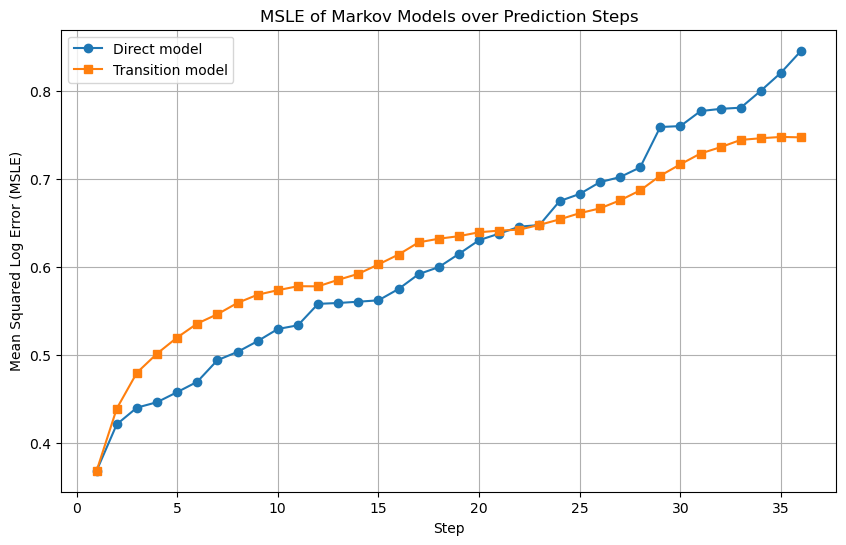

In [21]:
df = predictions_merged.copy()
df.dropna(inplace=True)


# define true values
y_true = df["ln_ged_sb"].values


direct_rmsle = []
transition_rmsle = []

for step in range(1, 37):

    direct_rmse_val = mean_squared_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"])
    transition_rmse_val = mean_squared_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"])

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()


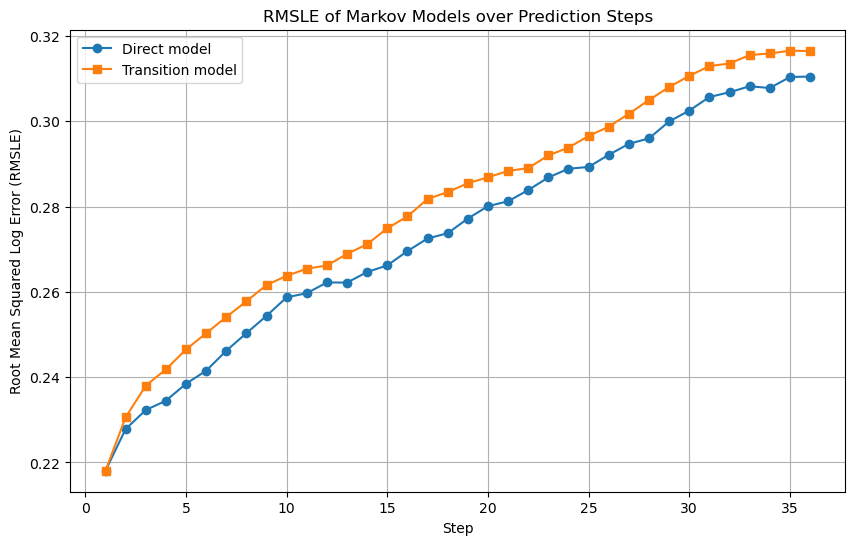

In [22]:
direct_rmsle = []
transition_rmsle = []

for step in range(1, 37):
    
    direct_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"]))
    transition_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"]))

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.xlabel("Step")
plt.ylabel("Root Mean Squared Log Error (RMSLE)")
plt.title("RMSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
predictions_direct.head()

step                        predicted_fatalities_t_min_1  \
country_id target_month_id                                 
1          409.0                                0.000000   
           410.0                                0.001422   
           411.0                                0.001417   
           412.0                                0.001402   
           413.0                                0.002836   

step                        predicted_fatalities_t_min_2  \
country_id target_month_id                                 
1          409.0                                     0.0   
           410.0                                     0.0   
           411.0                                     0.0   
           412.0                                     0.0   
           413.0                                     0.0   

step                        predicted_fatalities_t_min_3  \
country_id target_month_id                                 
1          409.0                                0.000000   
           410.0                                0.000000   
           411.0                                0.003009   
           412.0                                0.002987   
           413.0                                0.001569   

step                        predicted_fatalities_t_min_4  \
country_id target_month_id                                 
1          409.0                                     0.0   
           410.0                                     0.0   
           411.0                                     0.0   
           412.0                                     0.0   
           413.0                                     0.0   

step                        predicted_fatalities_t_min_5  \
country_id target_month_id                                 
1          409.0                                0.000000   
           410.0                                0.000000   
           411.0                                0.000000   
           412.0                                0.000000   
           413.0                                0.001505   

step                        predicted_fatalities_t_min_6  \
country_id target_month_id                                 
1          409.0                                0.006054   
           410.0                                0.006041   
           411.0                                0.006041   
           412.0                                0.006033   
           413.0                                0.007661   

step                        predicted_fatalities_t_min_7  \
country_id target_month_id                                 
1          409.0                                0.003119   
           410.0                                0.004643   
           411.0                                0.004622   
           412.0                                0.003111   
           413.0                                0.003110   

step                        predicted_fatalities_t_min_8  \
country_id target_month_id                                 
1          409.0                                0.002991   
           410.0                                0.003011   
           411.0                                0.003027   
           412.0                                0.003021   
           413.0                                0.004621   

step                        predicted_fatalities_t_min_9  \
country_id target_month_id                                 
1          409.0                                0.001473   
           410.0                                0.001495   
           411.0                                0.001505   
           412.0                                0.001514   
           413.0                                0.001510   

step                        predicted_fatalities_t_min_10  ...  \
country_id target_month_id                                 ...   
1          409.0                                 0.001611  ...   
           41

In [25]:
pg_to_country_id = pd.read_csv("/Users/views/Documents/VIEWS/Repos/fatalities_retrospective/data/pgid_to_countryid.csv")

In [26]:
pred = predictions_direct.copy().reset_index()

In [29]:
data_subset = data.reset_index()[["country_id", "month_id", "ln_ged_sb"]]

In [30]:
pred = pred.merge(data_subset, left_on=["country_id", "target_month_id"], right_on=["country_id", "month_id"], how="left")

In [31]:
pred.head()

,country_id,target_month_id,predicted_fatalities_t_min_1,predicted_fatalities_t_min_2,predicted_fatalities_t_min_3,predicted_fatalities_t_min_4,predicted_fatalities_t_min_5,predicted_fatalities_t_min_6,predicted_fatalities_t_min_7,predicted_fatalities_t_min_8,...,predicted_fatalities_t_min_29,predicted_fatalities_t_min_30,predicted_fatalities_t_min_31,predicted_fatalities_t_min_32,predicted_fatalities_t_min_33,predicted_fatalities_t_min_34,predicted_fatalities_t_min_35,predicted_fatalities_t_min_36,month_id,ln_ged_sb
0,1,409.0,0.000000,0.0,0.000000,0.0,0.000000,0.006054,0.003119,0.002991,...,0.000000,0.001383,0.001761,0.002785,0.0,0.005553,0.002765,0.0,409,0.0
1,1,410.0,0.001422,0.0,0.000000,0.0,0.000000,0.006041,0.004643,0.003011,...,0.000000,0.001379,0.001757,0.002785,0.0,0.005555,0.002777,0.0,410,0.0
2,1,411.0,0.001417,0.0,0.003009,0.0,0.000000,0.006041,0.004622,0.003027,...,0.000000,0.001379,0.001749,0.004149,0.0,0.005571,0.002778,0.0,411,0.0
3,1,412.0,0.001402,0.0,0.002987,0.0,0.000000,0.006033,0.003111,0.003021,...,0.000000,0.001386,0.001734,0.004138,0.0,0.005571,0.002785,0.0,412,0.0
4,1,413.0,0.002836,0.0,0.001569,0.0,0.001505,0.007661,0.003110,0.004621,...,0.006401,0.001383,0.001734,0.002759,0.0,0.005532,0.002785,0.0,413,0.0


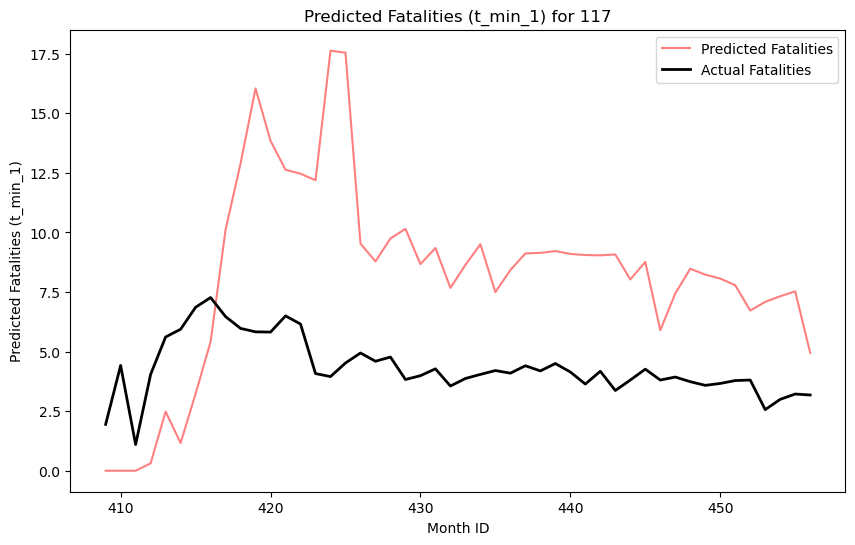

In [36]:
# plot predicted values for predicted_fatalites_t_min_1


# plot only for country_id == 4
country_name = 117
subset = pred[pred["country_id"] == country_name]

if subset.empty:
    print(f"No data available for country: {country_name}")
else:
    plt.figure(figsize=(10,6))
    plt.plot(subset["target_month_id"], np.expm1(subset["predicted_fatalities_t_min_3"]), label="Predicted Fatalities", color="red", alpha=0.5)
    plt.plot(subset["target_month_id"], subset["ln_ged_sb"], label="Actual Fatalities", color="black", linewidth=2)
    plt.legend()
    plt.xlabel("Month ID")
    plt.ylabel("Predicted Fatalities (t_min_1)")
    plt.title(f"Predicted Fatalities (t_min_1) for {country_name}")
    plt.show()


# Compare with David's predictions

In [44]:
results = pd.read_parquet('../r_version/results/markov_jointnarrow_ss_rf_custom.parquet')

In [50]:
predictions_david = results.reorder_levels(["country_id", "month_id"]).sort_index()
predictions_david.index.names = ["country_id", "target_month_id"]
predictions_david.head()

step_pred_1  step_pred_2  step_pred_3  \
country_id target_month_id                                          
1          409                 0.002469     0.001163     0.002988   
           410                 0.011577     0.001166     0.002989   
           411                 0.020260     0.012796     0.002986   
           412                 0.015608     0.008278     0.010349   
           413                 0.011613     0.007305     0.010349   

                            step_pred_4  step_pred_5  step_pred_6  \
country_id target_month_id                                          
1          409                 0.003841     0.004119     0.004385   
           410                 0.003837     0.010003     0.004385   
           411                 0.007799     0.009997     0.005853   
           412                 0.003841     0.010057     0.004395   
           413                 0.021947     0.010057     0.004395   

                            step_pred_7  step_pred_8  step_pred_9  \
country_id target_month_id                                          
1          409                 0.023190     0.001378     0.016227   
           410                 0.023190     0.001376     0.021991   
           411                 0.023216     0.004433     0.023917   
           412                 0.020173     0.001378     0.018579   
           413                 0.020184     0.001378     0.020890   

                            step_pred_10  ...  step_pred_27  step_pred_28  \
country_id target_month_id                ...                               
1          409                  0.009005  ...      0.018085      0.010051   
           410                  0.009013  ...      0.018085      0.010051   
           411                  0.009014  ...      0.057486      0.011630   
           412                  0.009010  ...      0.064109      0.051567   
           413                  0.009023  ...      0.064028      0.051676   

                            step_pred_29  step_pred_30  step_pred_31  \
country_id target_month_id                                             
1          409                  0.011953      0.002126      0.013408   
           410                  0.011978      0.002133      0.013414   
           411                  0.013497      0.005790      0.013451   
           412                  0.011965      0.002131      0.013499   
           413                  0.065690      0.002131      0.013499   

                            step_pred_32  step_pred_33  step_pred_34  \
country_id target_month_id                                             
1          409                  0.027273      0.014920      0.031802   
           410                  0.027273      0.014937      0.031802   
           411                  0.027306      0.014944      0.031818   
           412                  0.028032      0.014085      0.038124   
           413                  0.027954      0.014088      0.038111   

                            step_pred_35  step_pred_36  
country_id target_month_id                              
1          409                  0.020697      0.058458  
           410                  0.020663      0.058451  
           411                  0.024156      0.058451  
           412                  0.020628      0.050432  
           413                  0.020628      0.050432  

[5 rows x 36 columns]

In [51]:
predictions_merged.head()

predicted_fatalities_t_min_1_direct  \
country_id target_month_id                                        
1          409.0                                       0.000000   
           410.0                                       0.001422   
           411.0                                       0.001417   
           412.0                                       0.001402   
           413.0                                       0.002836   

                            predicted_fatalities_t_min_2_direct  \
country_id target_month_id                                        
1          409.0                                            0.0   
           410.0                                            0.0   
           411.0                                            0.0   
           412.0                                            0.0   
           413.0                                            0.0   

                            predicted_fatalities_t_min_3_direct  \
country_id target_month_id                                        
1          409.0                                       0.000000   
           410.0                                       0.000000   
           411.0                                       0.003009   
           412.0                                       0.002987   
           413.0                                       0.001569   

                            predicted_fatalities_t_min_4_direct  \
country_id target_month_id                                        
1          409.0                                            0.0   
           410.0                                            0.0   
           411.0                                            0.0   
           412.0                                            0.0   
           413.0                                            0.0   

                            predicted_fatalities_t_min_5_direct  \
country_id target_month_id                                        
1          409.0                                       0.000000   
           410.0                                       0.000000   
           411.0                                       0.000000   
           412.0                                       0.000000   
           413.0                                       0.001505   

                            predicted_fatalities_t_min_6_direct  \
country_id target_month_id                                        
1          409.0                                       0.006054   
           410.0                                       0.006041   
           411.0                                       0.006041   
           412.0                                       0.006033   
           413.0                                       0.007661   

                            predicted_fatalities_t_min_7_direct  \
country_id target_month_id                                        
1          409.0                                       0.003119   
           410.0                                       0.004643   
           411.0                                       0.004622   
           412.0                                       0.003111   
           413.0                                       0.003110   

                            predicted_fatalities_t_min_8_direct  \
country_id target_month_id                                        
1          409.0                                       0.002991   
           410.0                                       0.003011   
           411.0                                       0.003027   
           412.0                                       0.003021   
           413.0                                       0.004621   

                            predicted_fatalities_t_min_9_direct  \
country_id target_month_id                                        
1          409.0                                       0.001473   
           410.0                                       0.001495   


In [52]:
fully_merged = predictions_merged.merge(
    predictions_david,
    left_index=True,
    right_index=True,
)

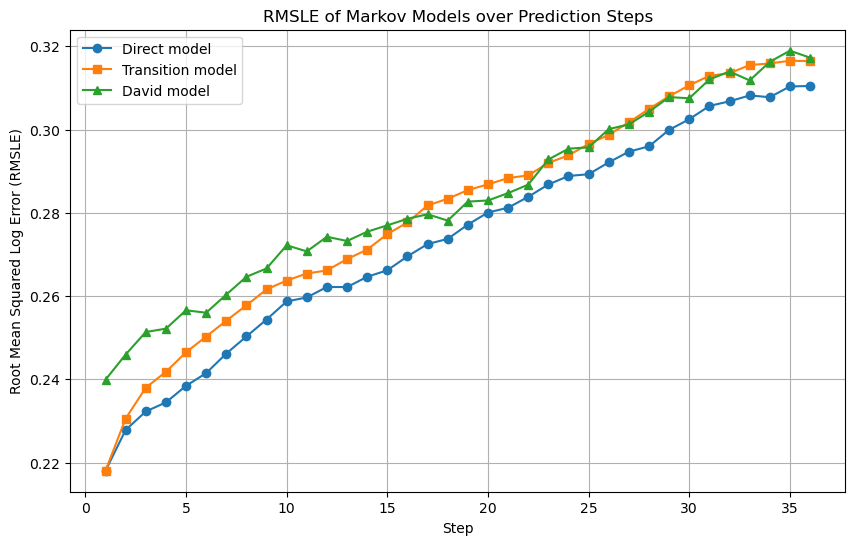

In [56]:
df = fully_merged.copy()
df.dropna(inplace=True)

# define true values
y_true = df["ln_ged_sb"].values

direct_rmsle = []
transition_rmsle = []
david_rmsle = []

for step in range(1, 37):
    
    direct_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"]))
    transition_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"]))
    david_rmse_val = np.sqrt(mean_squared_log_error(y_true, df[f"step_pred_{step}"]))

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)
    david_rmsle.append(david_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle,
    "david_rmsle": david_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.plot(rmsle_df["step"], rmsle_df["david_rmsle"], marker="^", label="David model")
plt.xlabel("Step")
plt.ylabel("Root Mean Squared Log Error (RMSLE)")
plt.title("RMSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()

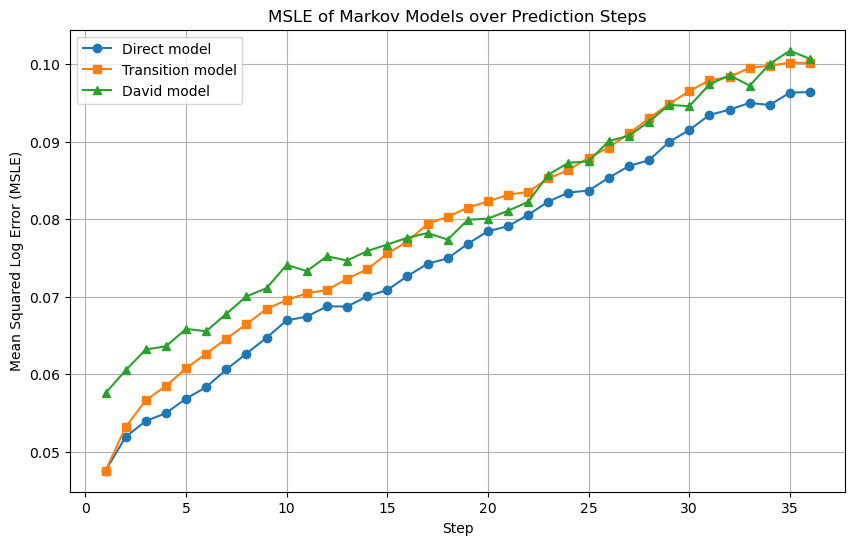

In [57]:
df = fully_merged.copy()
df.dropna(inplace=True)

# define true values
y_true = df["ln_ged_sb"].values

direct_rmsle = []
transition_rmsle = []
david_rmsle = []

for step in range(1, 37):
    
    direct_rmse_val = mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"])
    transition_rmse_val = mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"])
    david_rmse_val = mean_squared_log_error(y_true, df[f"step_pred_{step}"])

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)
    david_rmsle.append(david_rmse_val)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle,
    "david_rmsle": david_rmsle
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Direct model")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Transition model")
plt.plot(rmsle_df["step"], rmsle_df["david_rmsle"], marker="^", label="David model")
plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()

Then read in the predictions from David's new code:

In [58]:
new_data_david = pd.read_csv("../r_version/merged_predictions.csv")

In [60]:
new_data_david.set_index(["country_id", "target_month_id"], inplace=True)

In [61]:
new_data_david.head()

,,pred_step_1,pred_step_2,pred_step_3,pred_step_4,pred_step_5,pred_step_6,pred_step_7,pred_step_8,pred_step_9,pred_step_10,...,pred_step_27,pred_step_28,pred_step_29,pred_step_30,pred_step_31,pred_step_32,pred_step_33,pred_step_34,pred_step_35,pred_step_36
country_id,target_month_id,,,,,,,,,,,,,,,,,,,,,
1,409,0.000000,0.005589,0.006033,0.001857,0.007088,0.000000,0.001572,0.002450,0.014805,0.015094,...,0.017941,0.010453,0.009080,0.006078,0.007978,0.037893,0.012909,0.020922,0.040028,0.033303
2,409,0.000000,0.000000,0.000000,0.000000,0.001682,0.001212,0.001258,0.000000,0.000000,0.000000,...,0.000000,0.000621,0.001350,0.003716,0.000605,0.000622,0.000000,0.003789,0.004075,0.013602
3,409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,409,0.004946,0.004364,0.004275,0.003120,0.007530,0.006076,0.009659,0.014457,0.020202,0.047871,...,0.021454,0.007811,0.007652,0.003203,0.003854,0.022892,0.010756,0.045604,0.033064,0.066911
5,409,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [62]:
final_merged = fully_merged.merge(
    new_data_david,
    left_index=True,
    right_index=True,
)

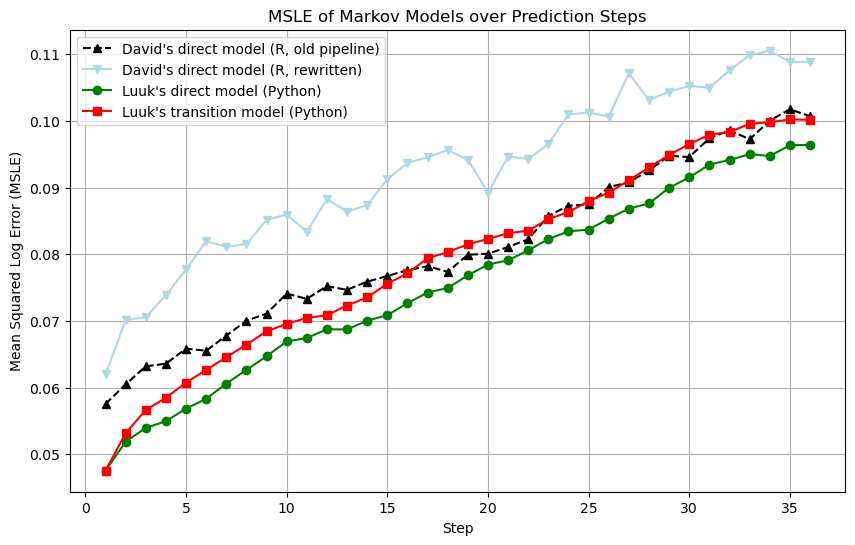

In [75]:
df = final_merged.copy()
df.dropna(inplace=True)

# define true values
y_true = df["ln_ged_sb"].values

direct_rmsle = []
transition_rmsle = []
david_rmsle = []
david_rmsle_new = []

for step in range(1, 37):
    
    direct_rmse_val = mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_direct"])
    transition_rmse_val = mean_squared_log_error(y_true, df[f"predicted_fatalities_t_min_{step}_transition"])
    david_rmse_val = mean_squared_log_error(y_true, df[f"step_pred_{step}"])
    david_rmse_val_new = mean_squared_log_error(y_true, df[f"pred_step_{step}"])

    direct_rmsle.append(direct_rmse_val)
    transition_rmsle.append(transition_rmse_val)
    david_rmsle.append(david_rmse_val)
    david_rmsle_new.append(david_rmse_val_new)

# combine into dataframe
rmsle_df = pd.DataFrame({
    "step": range(1, 37),
    "direct_rmsle": direct_rmsle,
    "transition_rmsle": transition_rmsle,
    "david_rmsle": david_rmsle,
    "david_rmsle_new": david_rmsle_new
})

# --- plot ---
plt.figure(figsize=(10,6))
plt.plot(rmsle_df["step"], rmsle_df["david_rmsle"], marker="^", label="David's direct model (R, old pipeline)", color = "black", linestyle = "--")
plt.plot(rmsle_df["step"], rmsle_df["david_rmsle_new"], marker="v", label="David's direct model (R, rewritten)", color = "lightblue")
plt.plot(rmsle_df["step"], rmsle_df["direct_rmsle"], marker="o", label="Luuk's direct model (Python)", color = "green")
plt.plot(rmsle_df["step"], rmsle_df["transition_rmsle"], marker="s", label="Luuk's transition model (Python)", color = "red")

plt.xlabel("Step")
plt.ylabel("Mean Squared Log Error (MSLE)")
plt.title("MSLE of Markov Models over Prediction Steps")
plt.legend()
plt.grid(True)
plt.show()